In [23]:
from fastai.vision import *
from pathlib import Path
import pickle
import sys
from operator import attrgetter
from PIL import Image as pil_im
import warnings
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/fulltrain'),
 PosixPath('data/image_shapes.pickle'),
 PosixPath('data/validation-annotations-bbox.csv'),
 PosixPath('data/fullvalidation'),
 PosixPath('data/models'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/class-descriptions-boxable.csv'),
 PosixPath('data/train-annotations-bbox.csv')]

In [ ]:
# load class names
class_names = pd.read_csv(PATH/'class-descriptions-boxable.csv', header=None, names=["LabelName", "Class"])
class_dict = class_names.set_index('LabelName').to_dict()['Class']

In [ ]:
#### Labels, bounding boxes for training and validation

In [ ]:
# load training labels
il_train = ImageList.from_folder(PATH/"fulltrain/", convert_mode='L')
labels_train = pd.read_csv(PATH/'train-annotations-bbox.csv')
labels_train['Class'] = [class_dict[item] for item in labels_train.LabelName]
labels_train.loc[:, "ImageID"] = labels_train.loc[:, "ImageID"].astype('category')

# load validation labels
il_val = ImageList.from_folder(PATH/"fullvalidation/", convert_mode='L')
labels_val = pd.read_csv(PATH/'validation-annotations-bbox.csv')
labels_val['Class'] = [class_dict[item] for item in labels_val.LabelName]
labels_val.loc[:, "ImageID"] = labels_val.loc[:, "ImageID"].astype('category')

In [ ]:
labels_train = labels_train.loc[labels_train["ImageID"].apply(lambda img_id: img_id + '.jpg').isin(os.listdir("data/fulltrain"))]
labels_val = labels_val.loc[labels_val["ImageID"].apply(lambda img_id: img_id + '.jpg').isin(os.listdir("data/fullvalidation"))]

In [ ]:
def get_XY(directory):
    """ Get the shape of all images in target directory"""
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        X = {}
        Y = {}
        for filepath in list(directory.iterdir()):
            try:
                #PIL
                X[filepath.stem], Y[filepath.stem] = pil_im.open(filepath).size
            except:
                #cv2
                Y[filepath.stem], X[filepath.stem] = imread(str(filepath)).shape[:-1]
    return X,Y

In [ ]:
X,Y = get_XY(PATH/'fulltrain')
ids_train = list(map(attrgetter('stem'), list(il_train.items)))
df_dict = labels_train.to_dict("list")
x = {image_id : {"bboxes" : [], "Classes" : []} for image_id in ids_train}
[x.update({image_id: {"bboxes" : x[image_id]["bboxes"] + [[ymax*Y[image_id],
                                                           xmin*X[image_id],
                                                           ymin*Y[image_id],
                                                           xmax*X[image_id]]],
                     "Classes" : x[image_id]["Classes"] + [c]}})
 for c, image_id, xmin, xmax, ymin, ymax
 in zip(df_dict["LabelName"], df_dict["ImageID"], 
        df_dict["XMin"], df_dict["XMax"], 
        df_dict["YMin"], df_dict["YMax"])
 if image_id in x
]
img2bbox_train = {image_id : [x[image_id]["bboxes"], x[image_id]["Classes"]] for image_id in ids_train if image_id in x}

In [ ]:
X,Y = get_XY(PATH/'fullvalidation')
ids_val = list(map(attrgetter('stem'), list(il_val.items)))
df_dict = labels_val.to_dict("list")
x = {image_id : {"bboxes" : [], "Classes" : []} for image_id in ids_val}
[x.update({image_id: {"bboxes" : x[image_id]["bboxes"] + [[ymax*Y[image_id],
                                                           xmin*X[image_id],
                                                           ymin*Y[image_id],
                                                           xmax*X[image_id]]],
                     "Classes" : x[image_id]["Classes"] + [c]}})
 for c, image_id, xmin, xmax, ymin, ymax
 in zip(df_dict["LabelName"], df_dict["ImageID"], 
        df_dict["XMin"], df_dict["XMax"], 
        df_dict["YMin"], df_dict["YMax"])
 if image_id in x
]
img2bbox_val = {image_id : [x[image_id]["bboxes"], x[image_id]["Classes"]] for image_id in ids_val if image_id in x}

In [ ]:
img2bbox = {**img2bbox_train, **img2bbox_val}

In [ ]:
%%script false
with open('i2b.pickle', 'wb') as f: 
    pickle.dump(img2bbox, f)

In [24]:
#%%script false
with open('i2b.pickle', 'rb') as f:
    img2bbox = pickle.load(f)

In [25]:
get_y_func = lambda o:img2bbox[o.stem]

In [27]:
data = ObjectItemList; print(1, type(data))
data = data.from_folder(path=PATH, convert_mode='RGB'); print(2, type(data))
data = data.use_partial_data(0.0001); print(3, type(data))
#data = data.split_by_folder(train='fulltrain', valid='fullvalidation'); print(4, type(data))
data = data.split_by_rand_pct(0.2)
data = data.label_from_func(get_y_func); print(6, type(data))
data = data.transform(None, size=128, tfm_y=True); print(7, type(data))
data = data.databunch(path=PATH, bs=16, collate_fn=bb_pad_collate); print(8, type(data))
data = data.normalize(imagenet_stats); print(9, type(data))

1 <class 'type'>
2 <class 'fastai.vision.data.ObjectItemList'>
3 <class 'fastai.vision.data.ObjectItemList'>
6 <class 'fastai.data_block.LabelLists'>
7 <class 'fastai.data_block.LabelLists'>
8 <class 'fastai.vision.data.ImageDataBunch'>
9 <class 'fastai.vision.data.ImageDataBunch'>


In [28]:
data

ImageDataBunch;

Train: LabelList (142 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: data;

Valid: LabelList (35 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: data;

Test: None

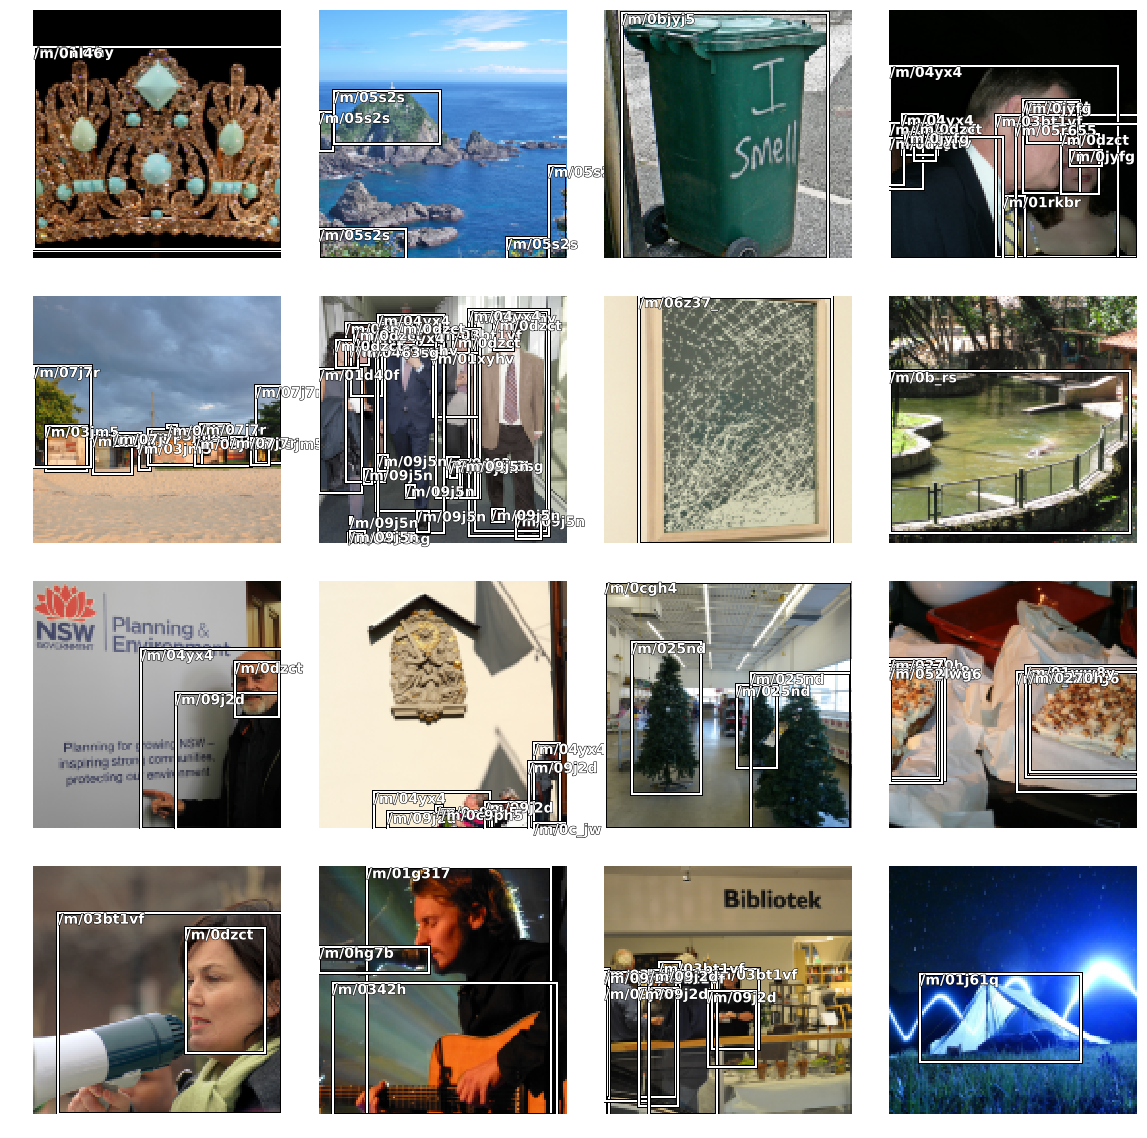

In [29]:
data.show_batch(rows=4)

In [ ]:
# backup
data = (ObjectItemList
        .from_folder(path=PATH, convert_mode='RGB')
        .use_partial_data(0.0001)
        .split_by_folder(train='fulltrain', valid='fullvalidation')
        .label_from_func(get_y_func)
        #.transform(get_transforms(), size=128, tfm_y=True)
        #.databunch(path=PATH, bs=16, collate_fn=bb_pad_collate)
        #.normalize(imagenet_stats)
       )